In [2]:
# try put back numba parallel  to "regression_mini_batch_v1"

import numpy as np
import matplotlib.pyplot as plt
import spikes4 as spk4
import snn_models

In [3]:
#%% Parameters
time_step = 1 # 1ms time resolution

lr = 0.002 # learning rate 0.005
thr = 0.6 #0.6 # v threshold
tau_out = 0.01 #1 # output decay time constant /// unit: ms
kappa = np.exp(-time_step/tau_out) # output decay
tau_mem = 20 # v decay time constant /// unit: ms
alpha = np.exp(-time_step/tau_mem) # v decay
beta = 0.2 # adaptation increment 
tau_a = 200 # adaptation decay time constant /// unit: ms
rho = np.exp(-time_step/(tau_a+1e-12)) # adaptation decay
t_ref = 1 #2 # refractory period /// unit: ms
c_reg = 20
f_target = 10*(1e-3) #10*(1e-3) # 10 Hz = 10*(1e-3) 1/ms
params = np.array([lr, thr, alpha, beta, kappa, rho, t_ref, c_reg, f_target]) # save as a vector

In [4]:
# prepare data for training
with open('spike_data95_fr_matched.npy','rb') as f:
    spike_data = np.load(f)
with open('linear_interpolated_y95.npy','rb') as g:
    linear_interpolated_y = np.load(g)

# Divide data in batches
nb_batch = 10 # number of batches
nb_inputs, nb_hidden, nb_outputs = 95, 100, 4  # set nb_outputs to 4 just for this part
batch_size = 8

nb_tstep = int(spike_data.shape[0]/nb_batch)
nb_tstep2 = int(spike_data.shape[0]/nb_batch/batch_size)
x = np.zeros((nb_batch, batch_size, nb_tstep2, nb_inputs))
y = np.zeros((nb_batch, batch_size, nb_tstep2, nb_outputs))

for batch_idx in range(nb_batch):
    for b in range(batch_size):
        x[batch_idx,b,:,:] = spike_data[nb_tstep*batch_idx:nb_tstep*(batch_idx+1),:][nb_tstep2*b:nb_tstep2*(b+1),:]
        y[batch_idx,b,:,:] = linear_interpolated_y[nb_tstep*batch_idx:nb_tstep*(batch_idx+1),:][nb_tstep2*b:nb_tstep2*(b+1),:] 
# Normalization
y = y/ np.max(np.abs(y))

print(x.shape)       
print(y.shape)      

(10, 8, 39266, 95)
(10, 8, 39266, 4)


In [5]:
# prepare data for validation
with open('spike_data95_fr_matched.npy','rb') as f:
    spike_data = np.load(f)
with open('linear_interpolated_y95.npy','rb') as g:
    linear_interpolated_y = np.load(g)

# Divide data in batches
nb_batch = 10 # number of batches
nb_inputs, nb_hidden, nb_outputs = 95, 100, 4  # set nb_outputs to 4 just for this part

nb_tstep = int(spike_data.shape[0]/nb_batch)
x2 = np.zeros((nb_batch, nb_tstep, nb_inputs))
y2 = np.zeros((nb_batch, nb_tstep, nb_outputs))
for b in range(nb_batch):
        x2[b,:,:] = spike_data[nb_tstep*b:nb_tstep*(b+1),:]
        y2[b,:,:] = linear_interpolated_y[nb_tstep*b:nb_tstep*(b+1),:]

# Normalization
y2 = y2/ np.max(np.abs(y2))
print(x2.shape)          # 10 batches, each batch contains 314130 ms long data, 95 channel
print(y2.shape)  

(10, 314130, 95)
(10, 314130, 4)


In [6]:
# 1 output case
nb_outputs = 1
y = y[:,:,:,0:1]
y2 = y2[:,:,0:1]

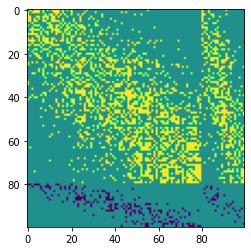

In [7]:
#%% initialize weight
weight_scale = 10*(1.0-alpha) #!!!
w1 = np.random.normal(size=(nb_inputs,nb_hidden), loc=0.0, scale=weight_scale/np.sqrt(nb_inputs)) # input-->hidden
w2 = np.random.normal(size=(nb_hidden,nb_outputs), loc=0.0, scale=weight_scale/np.sqrt(nb_hidden)) # hidden-->hidden
#bias = np.random.normal(size=(nb_outputs), loc=0.0, scale=weight_scale/np.sqrt(nb_outputs)) # output bias
bias = np.zeros(nb_outputs) # output bias
B = np.random.normal(size=(nb_outputs,nb_hidden), loc=0.0, scale=weight_scale/np.sqrt(nb_outputs)) #!!! random e-prop

#%% recurrent weights (choose only one)
############### (1) random network ###############
#wr = np.random.normal(size=(nb_hidden,nb_hidden), loc=0.0, scale=weight_scale/np.sqrt(nb_hidden)) # hidden-->output
#np.fill_diagonal(wr,0) # no self connectivity

############### (2) E/I network ###############
import graph_analysis
nb_e = int(nb_hidden*0.8)
nb_i = nb_hidden - nb_e
ind_fromi = np.zeros((nb_hidden,nb_hidden),dtype=bool)
ind_fromi[nb_e:,:] = True # index of inhibitory neurons

wr, xy, cdens = graph_analysis.aij_distance2d([1000,1000], [250,150], nb_e, nb_i, np.array([[1,-1],[1,-1]]), cself=False, plot=False, randomseed=None)
wr = wr.T
wr *= 0.05 # scaling

plt.imshow(wr) # visualize initial weights

In [8]:
# run it with smaller data set (here, reduce the number of timestep)
# 1 output case
#x = x[:,:,0:int(10000),:]      # ~25% of the data used  
#y = y[:,:,0:int(10000),0:1] 

x2 = x2[:,0:int(100000),:]      # ~30% of the data used  
y2 = y2[:,0:int(100000),0:1] 

# 4 output case
#x = x[:,0:int(31413*5),:]
#y = y[:,0:int(31413*5),:]

In [9]:
#%% run train

dw1_past = np.zeros((nb_inputs,nb_hidden))
dw2_past = np.zeros((nb_hidden,nb_outputs))
dwr_past = np.zeros((nb_hidden,nb_hidden))
dbias_past = np.zeros((nb_outputs,))
loss_train, fr_train, acc_train, spktr, wrs, atr = [],[],[],[],[],[]
loss_valid, fr_valid, acc_valid = [],[],[]
n_epochs = 35

for epoch in range(n_epochs): 
    ######################### train #########################
    loss_batch,fr_batch = np.zeros((nb_batch-1,)), np.zeros((nb_batch-1,))
    for batch_idx in range(nb_batch-1): # batch_idx = 0
        x_train, y_train = x[batch_idx,:,:,:].copy(),y[batch_idx,:,:,0:1].copy()
        loss, out_rec, dw1, dwr, dw2, dbias, v_rec, z_rec, a_rec = snn_models.lif_eprop3(w1,wr,w2,bias,B,x_train,y_train,params)
        dw1_past = 0.9*dw1_past + np.mean(dw1,0) #!!! momentum=0.9
        dw2_past = 0.9*dw2_past + np.mean(dw2,0) #!!! momentum=0.9
        dwr_past = 0.9*dwr_past + np.mean(dwr,0) #!!! momentum=0.9
        dbias_past = 0.9*dbias_past + np.mean(dbias,0) #!!! momentum=0.9
        
        w1 += dw1_past # input-->hidden update
        w2 += dw2_past # hidden-->hidden update
        wr += dwr_past # hidden-->output update
        bias += dbias_past # bias update
        
        # w1 += np.mean(dw1,0) # these are for no-momentum update (slow learning)
        # w2 += np.mean(dw2,0)
        # wr += np.mean(dwr,0)
        # bias += np.mean(dbias,0)
        # np.fill_diagonal(wr,0) # no-self connectivity

        #!!! below 5 lines are valid only for E/I network (uncomment when using random network) 
        ind_negative = wr<0
        ind = ind_negative*(~ind_fromi) # find negative & exciatory neurons
        wr[ind] = 0. # force the negative weights to 0
        ind = (~ind_negative)*ind_fromi # find positive & inhibitory neurons
        wr[ind] = 0. # force the positive weights to 0
        
        loss_batch[batch_idx] = loss.mean() # save loss
        fr_batch[batch_idx] = 1000*z_rec.mean() # save firing rate
        
    loss_train.append(loss_batch.mean()) # save loss 
    fr_train.append(fr_batch.mean()) # save firing rate
    print('EPOCH %d TRAIN) loss: %0.4f, fr: %0.4f Hz' %(epoch, loss_train[epoch], fr_train[epoch]))
   

    ######################### validate #########################
    x_valid, y_valid = x[-1,:,:,:].copy(),y[-1,:,:,0:1].copy() # last batch for validation
    loss, out_rec, dw1, dwr, dw2, dbias, v_rec, z_rec, a_rec = snn_models.lif_eprop3(w1,wr,w2,bias,B,x_valid,y_valid,params)
    
    loss_valid.append(loss.mean()) # save loss
    fr_valid.append(1000*z_rec.mean()) # save firing rate
    print('EPOCH %d VALID) loss: %0.4f, fr: %0.4f Hz' %(epoch, loss_valid[epoch], fr_valid[epoch]))
    
    spktr.append(z_rec[0]) # save spike train /// save one batch data only to save memory
    atr.append(a_rec[0]) # save a trace
    wrs.append(wr.copy()) # save weights
    
    ######################### save best weights #########################
    if loss_valid[-1] == min(loss_valid): # or you can use acc criteria instead
        w1_save,w2_save,wr_save,bias_save = w1.copy(),w2.copy(),wr.copy(),bias.copy()
        epoch_best = epoch
        
spktr = np.stack(spktr,0)
atr = np.stack(atr,0)
wrs = np.stack(wrs,0)
N = int(n_epochs/8) # epoch interval for plotting

EPOCH 0 TRAIN) loss: 0.2966, fr: 0.9291 Hz
EPOCH 0 VALID) loss: 0.3020, fr: 0.9150 Hz
EPOCH 1 TRAIN) loss: 0.2811, fr: 0.9423 Hz
EPOCH 1 VALID) loss: 0.2804, fr: 0.9705 Hz
EPOCH 2 TRAIN) loss: 0.2705, fr: 1.0428 Hz
EPOCH 2 VALID) loss: 0.2669, fr: 1.1324 Hz
EPOCH 3 TRAIN) loss: 0.2621, fr: 1.2563 Hz
EPOCH 3 VALID) loss: 0.2623, fr: 1.4042 Hz
EPOCH 4 TRAIN) loss: 0.2577, fr: 1.5539 Hz
EPOCH 4 VALID) loss: 0.2555, fr: 1.7393 Hz
EPOCH 5 TRAIN) loss: 0.2558, fr: 1.9078 Hz
EPOCH 5 VALID) loss: 0.2628, fr: 2.1070 Hz
EPOCH 6 TRAIN) loss: 0.2548, fr: 2.2862 Hz
EPOCH 6 VALID) loss: 0.2598, fr: 2.4902 Hz
EPOCH 7 TRAIN) loss: 0.2523, fr: 2.6640 Hz
EPOCH 7 VALID) loss: 0.2542, fr: 2.8569 Hz
EPOCH 8 TRAIN) loss: 0.2484, fr: 3.0181 Hz
EPOCH 8 VALID) loss: 0.2541, fr: 3.2046 Hz
EPOCH 9 TRAIN) loss: 0.2474, fr: 3.3592 Hz
EPOCH 9 VALID) loss: 0.2509, fr: 3.5406 Hz
EPOCH 10 TRAIN) loss: 0.2451, fr: 3.6858 Hz
EPOCH 10 VALID) loss: 0.2511, fr: 3.8610 Hz
EPOCH 11 TRAIN) loss: 0.2443, fr: 3.9968 Hz
EPOCH 11

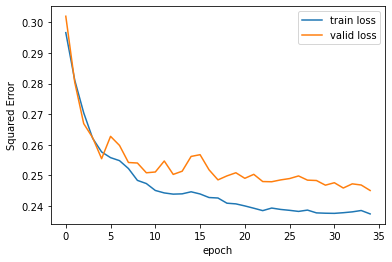

In [10]:
plt.plot(loss_train, label='train loss')
plt.plot(loss_valid, label='valid loss')
plt.xlabel("epoch")
plt.ylabel("Squared Error")
plt.legend()

In [11]:
# plotting example decode with best weight
#x_valid,y_valid = x[-1,:,:,:].copy(),y[-1,:,:,0:1].copy() # last batch for validation
x_valid,y_valid = x2[-1,:,:].copy(),y2[-1,:,0:1].copy() # last batch for validation
loss, out_rec, dw1, dwr, dw2, dbias, v_rec, z_rec, a_rec = snn_models.lif_eprop2(w1_save,wr_save,w2_save,bias_save,B,x_valid,y_valid,params)

In [12]:
# Reduce resolution to 100ms for plotting
length = round(out_rec.shape[1]/100)

y_valid_100ms = np.zeros(length)   # y_valid with 100ms resolution
out_rec_100ms = np.zeros(length)   # out_rec with 100ms resolution
for i in range(length):
    out_rec_100ms[i] = out_rec[0,i*100,0]
    y_valid_100ms[i] = y2[-1,i*100,0]

correlation= 0.044554284317855436


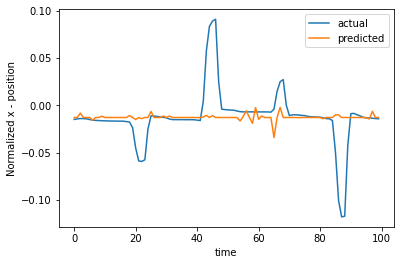

correlation= 0.06973631695357095


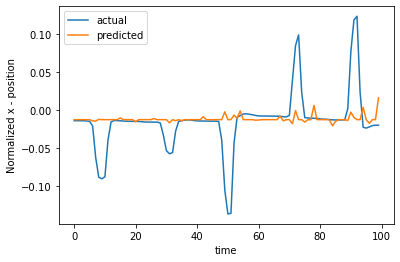

correlation= -0.2608353123173499


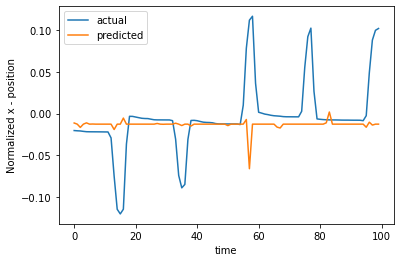

correlation= 0.03354207013149653


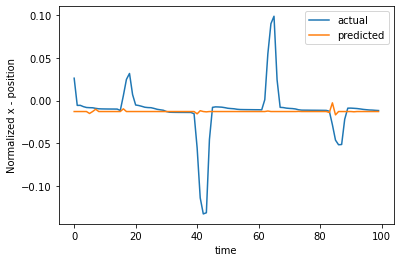

correlation= 0.2832139125141649


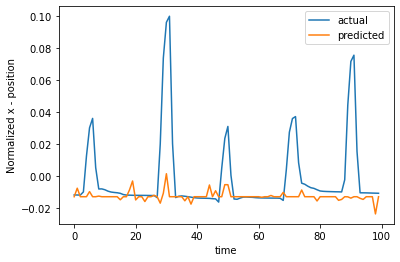

correlation= 0.11821297667952402


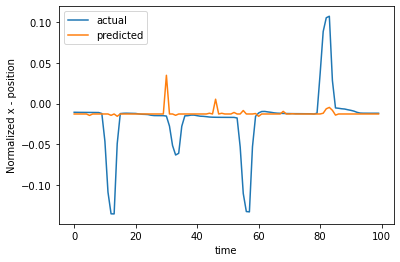

correlation= -0.11312196410370759


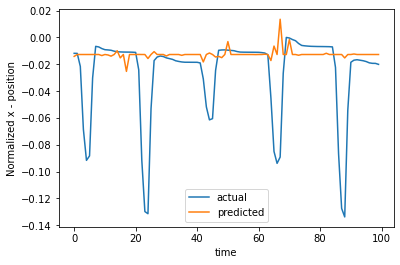

correlation= 0.029970399469960836


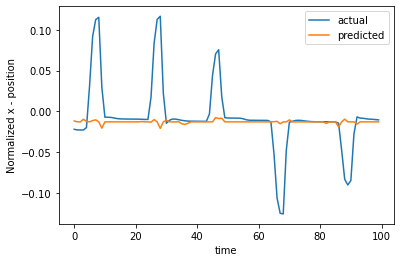

correlation= -0.033412148692902606


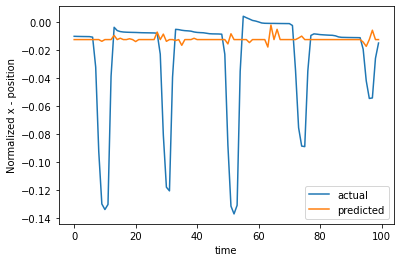

correlation= 0.0762874039811746


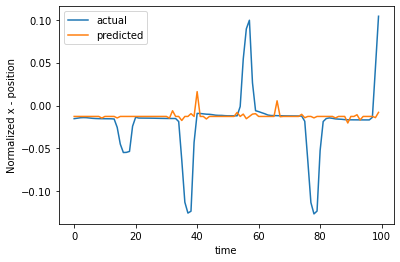

In [13]:
plt.figure()

for i in range(10):
    plt.plot(y_valid_100ms[100*i:100*(i+1)], label='actual')
    plt.plot(out_rec_100ms[100*i:100*(i+1)], label='predicted')
    correlation = np.corrcoef(y_valid_100ms[100*i:100*(i+1)],out_rec_100ms[100*i:100*(i+1)])
    print("correlation=", correlation[0,1])
    plt.ylabel("Normalized x - position")
    plt.xlabel("time")
    plt.legend()
    plt.show()

In [14]:
np.corrcoef(y_valid_100ms, out_rec_100ms)

array([[ 1.        , -0.01165122],
       [-0.01165122,  1.        ]])